# CMMA with Log Prices and Dynamic Position Sizing

This notebook explores a CMMA-filtered mean reversion strategy using log prices for the CMMA calculation and dynamic position sizing based on price deviation from fair price.

In [1]:
import sys
import os

# Import our backtester package
sys.path.append(os.path.abspath('../../'))
from backtester import get_price_data, get_vwap
print("Using backtester package")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to import seaborn, but don't fail if it's not available
try:
    import seaborn as sns
    print(f"Seaborn version: {sns.__version__}")
    sns.set(style="whitegrid")
    HAS_SEABORN = True
except ImportError:
    print("Seaborn not available, using matplotlib instead")
    HAS_SEABORN = False

Using backtester package
Seaborn version: 0.13.2


## 1. Load Data

First, let's load the Squid_Ink price data and limit it to the first 20,000 timestamps (in-sample data).

In [2]:
# Load data directly using backtester package
print("Loading price data...")
prices = get_price_data('SQUID_INK', 1)
print(f"Loaded {len(prices)} price data points")

# Limit to first 20,000 timestamps (in-sample data)
in_sample_prices = prices.iloc[:20000]
print(f"Limited to {len(in_sample_prices)} in-sample data points")

# Get VWAP
print("Getting VWAP for SQUID_INK...")
squid_vwap = in_sample_prices['vwap']
print(f"Got VWAP with {len(squid_vwap)} data points")
print(f"VWAP range: {squid_vwap.min()} to {squid_vwap.max()}")

# Calculate log prices
log_prices = np.log(squid_vwap)
print(f"Calculated log prices with {len(log_prices)} data points")

# Calculate returns
returns = squid_vwap.pct_change().dropna()
print(f"Calculated returns with {len(returns)} data points")

Loading price data...
Loading real data for SQUID_INK from round 1...
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-2.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_0.csv
Successfully loaded real data with 30000 rows
Loaded 30000 price data points
Limited to 20000 in-sample data points
Getting VWAP for SQUID_INK...
Got VWAP with 20000 data points
VWAP range: 1832.0 to 2187.3880597014927
Calculated log prices with 20000 data points
Calculated returns with 19999 data points


## 2. Calculate CMMA with Log Prices

Let's calculate the CMMA indicator using log prices instead of raw prices.

In [18]:
def calculate_cmma_log(log_prices, lookback=10):
    """
    Compute the Cumulative Moving Average Momentum (CMMA) using log prices.
    
    Parameters:
        log_prices (pd.Series): Series of log prices
        lookback (int): Lookback period
        
    Returns:
        pd.Series: CMMA indicator (0-1 range)
    """
    # Calculate raw CMMA using log prices
    # raw_cmma = (log_prices - log_prices.rolling(lookback).mean().shift(1)).divide(np.sqrt(lookback+1)).dropna()
    raw_cmma = (log_prices - log_prices.ewm(span=lookback).mean().shift(1)).divide(np.sqrt(lookback+1)).dropna()

    # Normalize using sigmoid function
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    cmma = sigmoid(raw_cmma)
    return cmma

# Calculate CMMA with different lookback periods
lookback_periods = [10, 20, 50, 100]
cmma_indicators = {}

for lookback in lookback_periods:
    cmma_indicators[f'CMMA_{lookback}'] = calculate_cmma_log(squid_vwap, lookback)

# Create a DataFrame with CMMA indicators
cmma_df = pd.DataFrame(cmma_indicators)

# Display the first few rows
cmma_df.head(10)

,CMMA_10,CMMA_20,CMMA_50,CMMA_100
timestamp,,,,
100,0.445531,0.460504,0.474625,0.481961
200,0.453617,0.465400,0.477396,0.483842
300,0.436062,0.451822,0.468328,0.477311
400,0.419898,0.438657,0.459283,0.470739
500,0.480713,0.480994,0.485814,0.489444
600,0.522771,0.511824,0.505634,0.503525
700,0.627487,0.590416,0.556991,0.540218
800,0.636450,0.602580,0.566889,0.547729
900,0.493653,0.503493,0.504745,0.503875


## 3. Visualize CMMA and Price Data

Let's visualize the CMMA indicator and price data to understand their relationship.

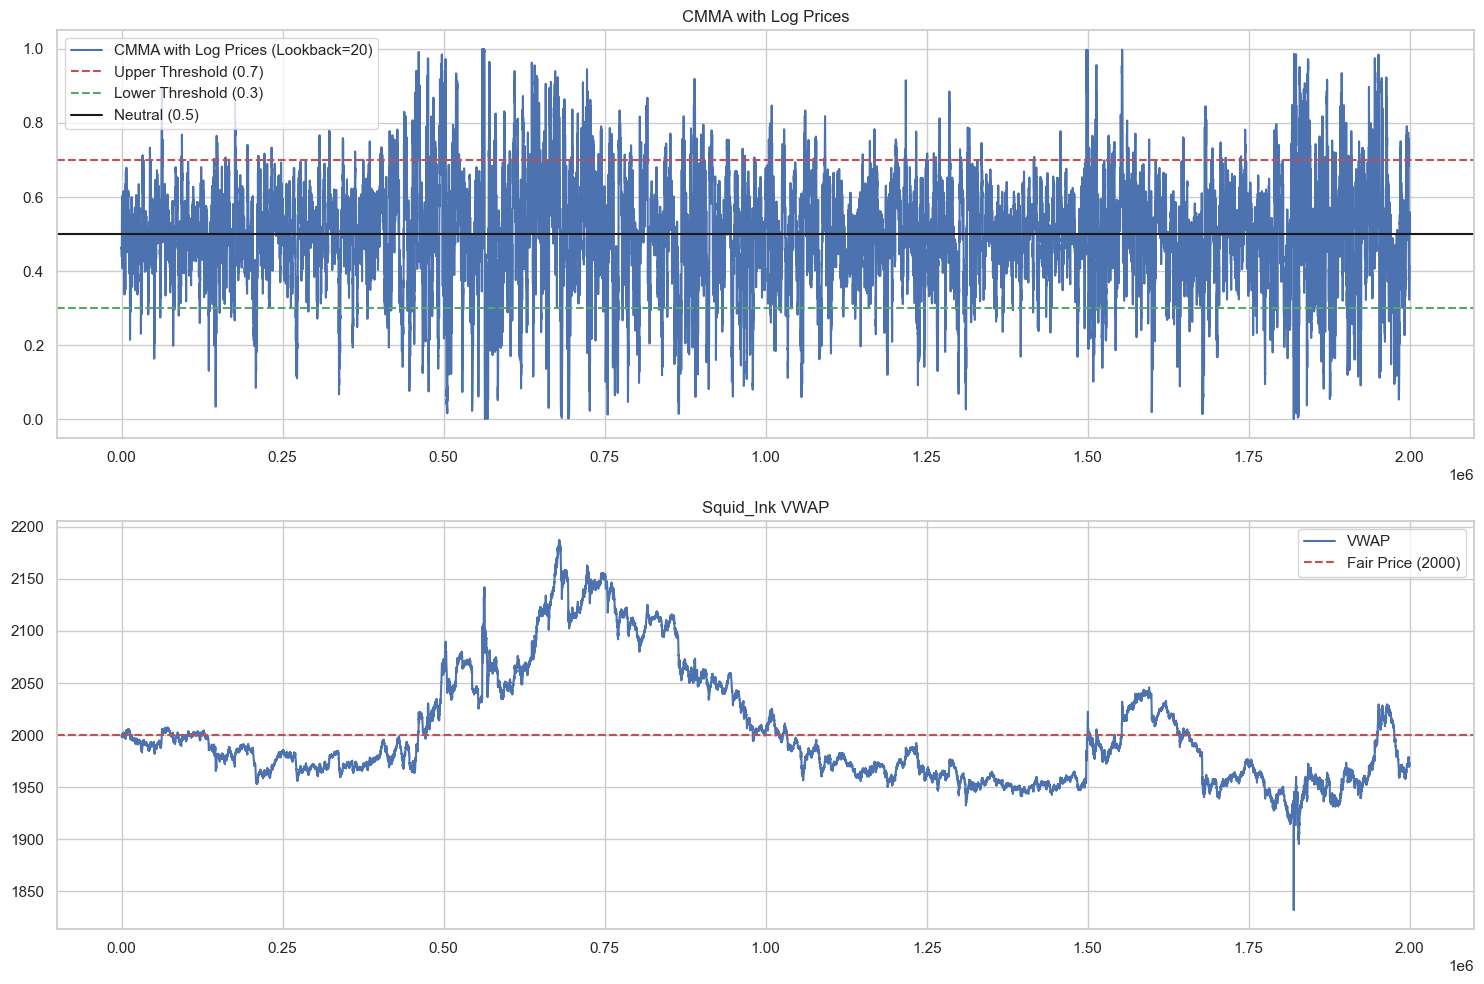

In [19]:
# Choose a specific lookback period for visualization
lookback = 20
cmma_log = cmma_indicators[f'CMMA_{lookback}']

# Plot CMMA and price
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(cmma_log, label=f'CMMA with Log Prices (Lookback={lookback})')
plt.axhline(y=0.7, color='r', linestyle='--', label='Upper Threshold (0.7)')
plt.axhline(y=0.3, color='g', linestyle='--', label='Lower Threshold (0.3)')
plt.axhline(y=0.5, color='k', linestyle='-', label='Neutral (0.5)')
plt.title('CMMA with Log Prices')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(squid_vwap, label='VWAP')
plt.axhline(y=2000, color='r', linestyle='--', label='Fair Price (2000)')
plt.title('Squid_Ink VWAP')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. Implement Dynamic Position Sizing Functions

Now, let's implement functions for dynamic position sizing based on price deviation from fair price and CMMA values.

In [20]:
def calculate_exponential_position(price, fair_price=2000, price_range=200, exponent=2.0, max_position=1.0):
    """
    Calculate position size that scales exponentially as price moves away from fair price.
    
    Parameters:
        price (float): Current price
        fair_price (float): Fair price (position is 0 at this price)
        price_range (float): Base price range for scaling
        exponent (float): Exponent for scaling (higher = more aggressive exponential growth)
        max_position (float): Maximum position size (absolute value)
        
    Returns:
        float: Position size between -max_position and max_position
    """
    # Calculate normalized deviation from fair price
    normalized_deviation = (price - fair_price) / price_range
    
    # Calculate position size using exponential scaling (negative deviation = positive position)
    if normalized_deviation > 0:
        # Price is above fair price -> short position
        position = -np.sign(normalized_deviation) * min(abs(normalized_deviation) ** exponent, 1.0) * max_position
    else:
        # Price is below fair price -> long position
        position = -np.sign(normalized_deviation) * min(abs(normalized_deviation) ** exponent, 1.0) * max_position
    
    return position

In [21]:
def cmma_dynamic_position_strategy(prices, cmma, fair_price, upper_threshold=0.7, lower_threshold=0.3, 
                                  price_range=200, exponent=2.0, max_position=1.0, update_frequency=1):
    """
    Implement a CMMA-filtered mean reversion strategy with dynamic position sizing.
    
    Parameters:
        prices (pd.Series): Series of prices
        cmma (pd.Series): CMMA indicator
        fair_price (float): Fair price to revert to
        upper_threshold (float): Upper threshold for CMMA
        lower_threshold (float): Lower threshold for CMMA
        price_range (float): Base price range for scaling positions
        exponent (float): Exponent for scaling (higher = more aggressive exponential growth)
        max_position (float): Maximum position size (absolute value)
        update_frequency (int): Number of timestamps between position updates
        
    Returns:
        pd.Series: Portfolio positions (continuous values between -max_position and max_position)
    """
    # Initialize positions
    positions = pd.Series(0.0, index=prices.index)
    
    # Get valid indices where CMMA is not NaN
    valid_indices = cmma.dropna().index
    
    # Track the last update time
    last_update_idx = -update_frequency  # Start with immediate update
    current_position = 0.0
    
    # Set positions based on CMMA and fair price
    for time in valid_indices:
        # Get the current price and CMMA value
        current_price = prices.loc[time]
        current_cmma = cmma.loc[time]
        
        # Get the index position
        idx = prices.index.get_loc(time)
        
        # Only update position at specified frequency
        if idx - last_update_idx >= update_frequency:
            # ONLY short above fair price when CMMA is high (strong momentum)
            if current_price > fair_price and current_cmma > upper_threshold:
                # Calculate dynamic position size (short)
                current_position = calculate_exponential_position(
                    current_price, fair_price, price_range, exponent, max_position
                )
                # Ensure it's a short position (negative)
                current_position = min(current_position, 0.0)
            
            # ONLY buy below fair price when CMMA is low (weak momentum)
            elif current_price < fair_price and current_cmma < lower_threshold:
                # Calculate dynamic position size (long)
                current_position = calculate_exponential_position(
                    current_price, fair_price, price_range, exponent, max_position
                )
                # Ensure it's a long position (positive)
                current_position = max(current_position, 0.0)
            else:
                # No signal, close position
                current_position = 0.0
                
            # Update last update index
            last_update_idx = idx
        
        # Set the current position
        positions.iloc[idx] = current_position
    
    return positions

In [22]:
# For comparison, let's also implement the original fixed-position strategy
def filtered_cmma_strategy(prices, cmma, fair_price, upper_threshold=0.7, lower_threshold=0.3, holding_period=10):
    """
    Implement a filtered CMMA-based mean reversion strategy with fixed position sizes.
    
    Parameters:
        prices (pd.Series): Series of prices
        cmma (pd.Series): CMMA indicator
        fair_price (float): Fair price to revert to
        upper_threshold (float): Upper threshold for CMMA
        lower_threshold (float): Lower threshold for CMMA
        holding_period (int): Number of periods to hold the position
        
    Returns:
        pd.Series: Portfolio positions (1 for long, -1 for short, 0 for no position)
    """
    # Initialize positions
    positions = pd.Series(0, index=prices.index)
    
    # Get valid indices where CMMA is not NaN
    valid_indices = cmma.dropna().index
    
    # Set positions based on CMMA and fair price
    for time in valid_indices:
        # Get the current price and CMMA value
        current_price = prices.loc[time]
        current_cmma = cmma.loc[time]
        
        # Get the index position
        idx = prices.index.get_loc(time)
        
        # ONLY short above fair price when CMMA is high (strong momentum)
        if current_price > fair_price and current_cmma > upper_threshold:
            # Set short position for holding period
            end_idx = min(idx + holding_period + 1, len(positions))
            positions.iloc[idx+1:end_idx] = -1
        
        # ONLY buy below fair price when CMMA is low (weak momentum)
        elif current_price < fair_price and current_cmma < lower_threshold:
            # Set long position for holding period
            end_idx = min(idx + holding_period + 1, len(positions))
            positions.iloc[idx+1:end_idx] = 1
    
    return positions

## 5. Test Dynamic Position Sizing Strategy

Let's test the dynamic position sizing strategy with different parameters and compare it with the fixed position strategy.

In [23]:
# Define the fair price
FAIR_PRICE = 2000

# Choose a specific lookback period for testing
lookback = 20
cmma_log = cmma_indicators[f'CMMA_{lookback}']

# Define parameters for testing
upper_threshold = 0.7  # Upper threshold for CMMA
lower_threshold = 0.3  # Lower threshold for CMMA
holding_period = 10    # Holding period for fixed strategy

# Parameters for dynamic position sizing
price_range = 200      # Base price range for scaling
exponent = 2.0         # Exponent for scaling
max_position = 1.0     # Maximum position size
update_frequency = 1   # Update frequency

# Run the fixed position strategy
fixed_positions = filtered_cmma_strategy(
    squid_vwap, cmma_log, FAIR_PRICE, upper_threshold, lower_threshold, holding_period
)

# Run the dynamic position strategy
dynamic_positions = cmma_dynamic_position_strategy(
    squid_vwap, cmma_log, FAIR_PRICE, upper_threshold, lower_threshold,
    price_range, exponent, max_position, update_frequency
)

# Calculate strategy returns
fixed_returns = fixed_positions.shift(1) * returns
fixed_returns = fixed_returns.dropna()

dynamic_returns = dynamic_positions.shift(1) * returns
dynamic_returns = dynamic_returns.dropna()

# Calculate performance metrics
fixed_total_return = fixed_returns.sum()
fixed_sharpe_ratio = fixed_returns.mean() / fixed_returns.std() * np.sqrt(252)  # Annualized
fixed_win_rate = (fixed_returns > 0).mean()

dynamic_total_return = dynamic_returns.sum()
dynamic_sharpe_ratio = dynamic_returns.mean() / dynamic_returns.std() * np.sqrt(252)  # Annualized
dynamic_win_rate = (dynamic_returns > 0).mean()

# Count the number of trades
fixed_num_trades = (fixed_positions.diff() != 0).sum()
dynamic_num_trades = (dynamic_positions.diff() != 0).sum()

# Print performance metrics
print("Fixed Position Strategy:")
print(f"Total Return: {fixed_total_return:.4f}")
print(f"Sharpe Ratio: {fixed_sharpe_ratio:.4f}")
print(f"Win Rate: {fixed_win_rate:.4f}")
print(f"Number of Trades: {fixed_num_trades}")
print()

print("Dynamic Position Strategy:")
print(f"Total Return: {dynamic_total_return:.4f}")
print(f"Sharpe Ratio: {dynamic_sharpe_ratio:.4f}")
print(f"Win Rate: {dynamic_win_rate:.4f}")
print(f"Number of Trades: {dynamic_num_trades}")

Fixed Position Strategy:
Total Return: -0.1071
Sharpe Ratio: -0.1644
Win Rate: 0.1075
Number of Trades: 443

Dynamic Position Strategy:
Total Return: 0.0452
Sharpe Ratio: 0.1681
Win Rate: 0.0462
Number of Trades: 2267


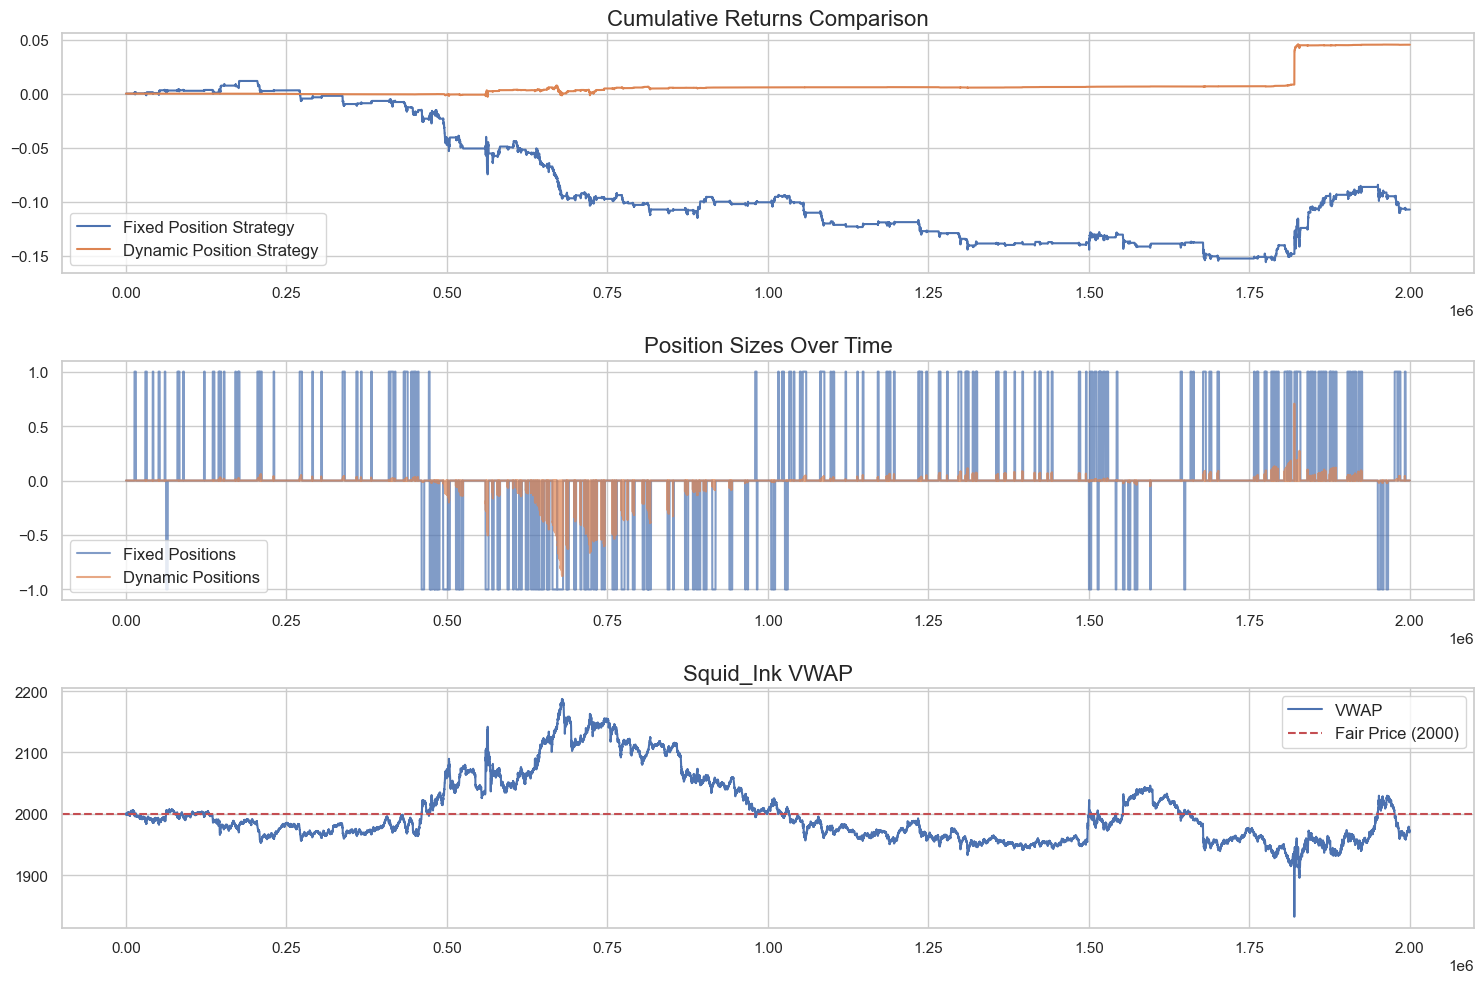

In [24]:
# Plot cumulative returns
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(fixed_returns.cumsum(), label='Fixed Position Strategy')
plt.plot(dynamic_returns.cumsum(), label='Dynamic Position Strategy')
plt.title('Cumulative Returns Comparison', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(fixed_positions, label='Fixed Positions', alpha=0.7)
plt.plot(dynamic_positions, label='Dynamic Positions', alpha=0.7)
plt.title('Position Sizes Over Time', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(squid_vwap, label='VWAP')
plt.axhline(y=FAIR_PRICE, color='r', linestyle='--', label='Fair Price (2000)')
plt.title('Squid_Ink VWAP', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

## 6. Optimize Dynamic Position Sizing Parameters

Let's test different parameter combinations for the dynamic position sizing strategy to find the optimal settings.

In [25]:
# Define parameter ranges to test
price_ranges = [100, 200, 300]       # Base price ranges for scaling
exponents = [0, 0.5,1.0, 1.5, 2.0, 2.5]     # Exponents for scaling
max_positions = [1.0]      # Maximum position sizes
update_frequencies = [1]      # Update frequencies

# Initialize results dictionary
param_results = []

# Test different parameter combinations
for price_range in price_ranges:
    for exponent in exponents:
        for max_position in max_positions:
            for update_freq in update_frequencies:
                # Run the dynamic position strategy
                dynamic_positions = cmma_dynamic_position_strategy(
                    squid_vwap, cmma_log, FAIR_PRICE, upper_threshold, lower_threshold,
                    price_range, exponent, max_position, update_freq
                )
                
                # Calculate strategy returns
                dynamic_returns = dynamic_positions.shift(1) * returns
                dynamic_returns = dynamic_returns.dropna()
                
                # Calculate performance metrics
                total_return = dynamic_returns.sum()
                sharpe_ratio = dynamic_returns.mean() / dynamic_returns.std() * np.sqrt(252)  # Annualized
                win_rate = (dynamic_returns > 0).mean()
                
                # Count the number of trades
                num_trades = (dynamic_positions.diff() != 0).sum()
                
                # Store results
                param_results.append({
                    'Price Range': price_range,
                    'Exponent': exponent,
                    'Max Position': max_position,
                    'Update Frequency': update_freq,
                    'Total Return': total_return,
                    'Sharpe Ratio': sharpe_ratio,
                    'Win Rate': win_rate,
                    'Number of Trades': num_trades
                })

# Convert results to DataFrame
param_df = pd.DataFrame(param_results)

# Sort by Total Return (descending)
param_df = param_df.sort_values('Total Return', ascending=False)

# Display top 10 parameter combinations
param_df.head(10)

,Price Range,Exponent,Max Position,Update Frequency,Total Return,Sharpe Ratio,Win Rate,Number of Trades
2,100,1.0,1.0,1,0.104915,0.217087,0.046202,2025
3,100,1.5,1.0,1,0.104229,0.223260,0.046202,2025
4,100,2.0,1.0,1,0.101423,0.222252,0.046202,2025
1,100,0.5,1.0,1,0.099169,0.192765,0.046202,2025
5,100,2.5,1.0,1,0.098024,0.218382,0.046202,2025
7,200,0.5,1.0,1,0.079460,0.187316,0.046202,2267
0,100,0.0,1.0,1,0.070119,0.117453,0.046202,939
12,300,0.0,1.0,1,0.070119,0.117453,0.046202,939
6,200,0.0,1.0,1,0.070119,0.117453,0.046202,939
8,200,1.0,1.0,1,0.067502,0.193600,0.046202,2267


## 7. Analyze Best Parameter Combination

Let's analyze the performance of the strategy with the best parameter combination.

Best parameter combination:
Price Range: 100.0
Exponent: 1.0
Max Position: 1.0
Update Frequency: 1.0
Total Return: 0.1049
Sharpe Ratio: 0.2171
Win Rate: 0.0462
Number of Trades: 2025


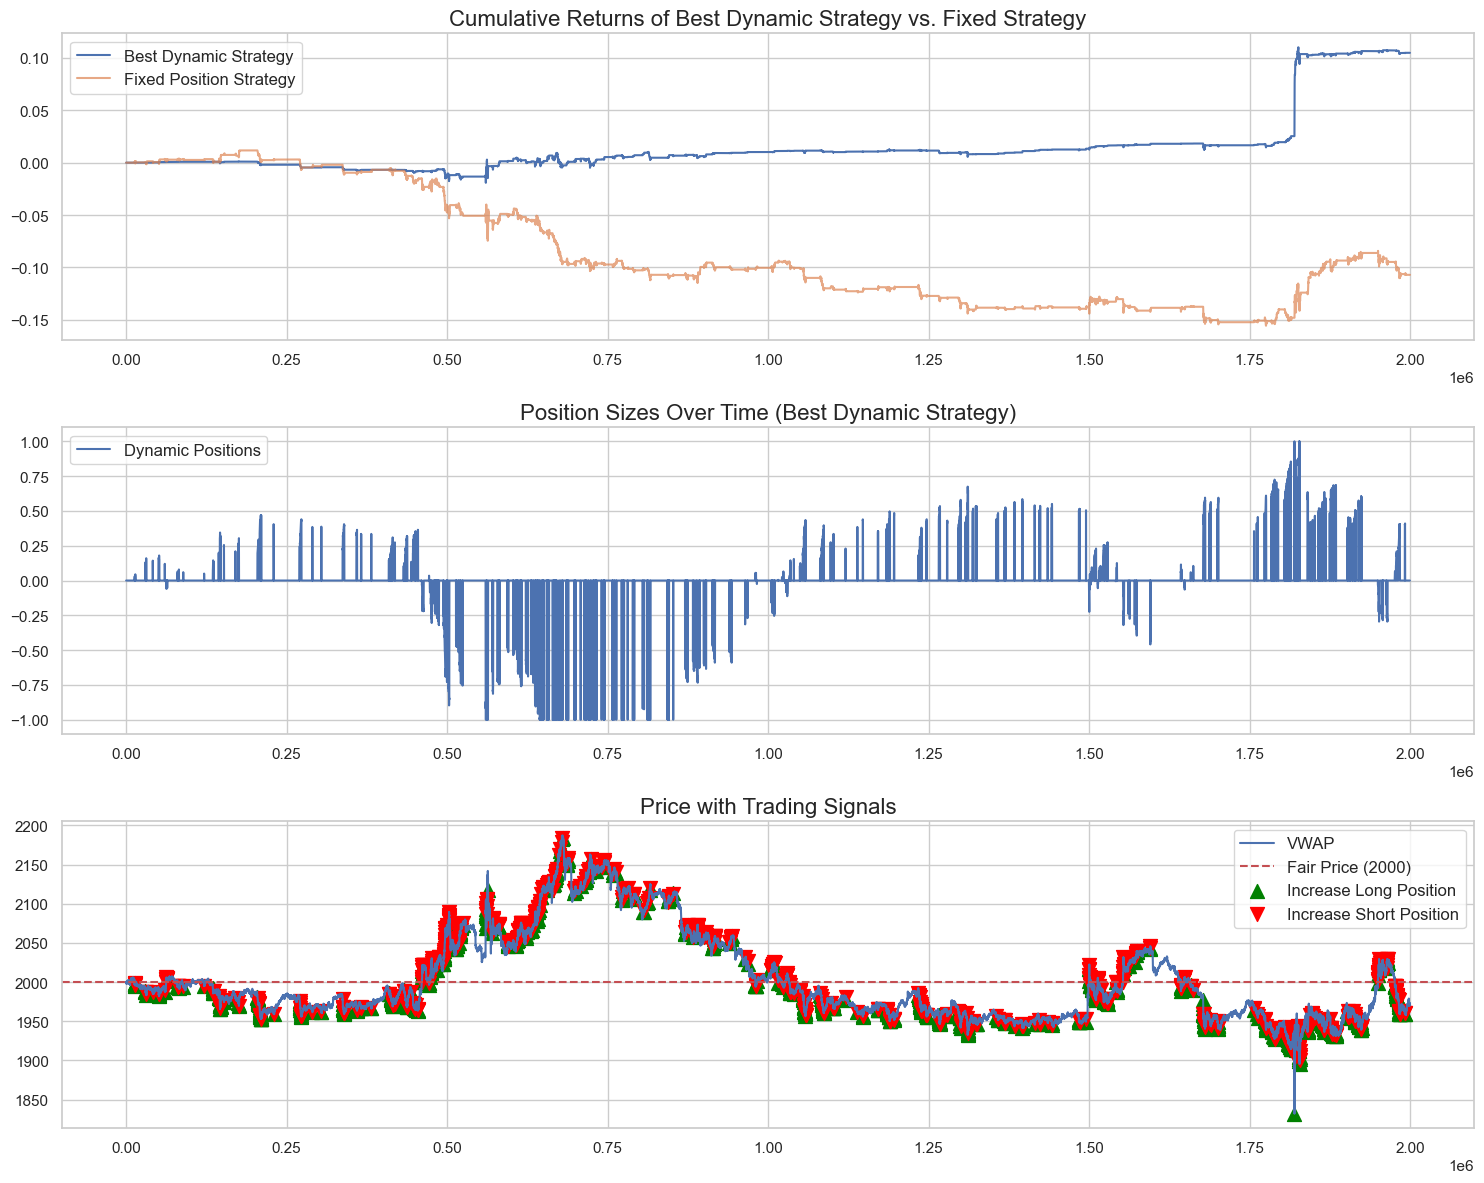

In [26]:
# Get the best parameter combination
best_params = param_df.iloc[0]

print(f'''Best parameter combination:
Price Range: {best_params['Price Range']}
Exponent: {best_params['Exponent']}
Max Position: {best_params['Max Position']}
Update Frequency: {best_params['Update Frequency']}
Total Return: {best_params['Total Return']:.4f}
Sharpe Ratio: {best_params['Sharpe Ratio']:.4f}
Win Rate: {best_params['Win Rate']:.4f}
Number of Trades: {int(best_params['Number of Trades'])}''')

# Run the strategy with the best parameters
best_dynamic_positions = cmma_dynamic_position_strategy(
    squid_vwap, cmma_log, FAIR_PRICE, upper_threshold, lower_threshold,
    best_params['Price Range'], best_params['Exponent'], 
    best_params['Max Position'], best_params['Update Frequency']
)

# Calculate strategy returns
best_dynamic_returns = best_dynamic_positions.shift(1) * returns
best_dynamic_returns = best_dynamic_returns.dropna()

# Plot cumulative returns and positions
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
plt.plot(best_dynamic_returns.cumsum(), label='Best Dynamic Strategy')
plt.plot(fixed_returns.cumsum(), label='Fixed Position Strategy', alpha=0.7)
plt.title(f'Cumulative Returns of Best Dynamic Strategy vs. Fixed Strategy', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(best_dynamic_positions, label='Dynamic Positions')
plt.title('Position Sizes Over Time (Best Dynamic Strategy)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(squid_vwap, label='VWAP')
plt.axhline(y=FAIR_PRICE, color='r', linestyle='--', label='Fair Price (2000)')

# Plot buy and sell signals
buy_signals = best_dynamic_positions.diff() > 0
sell_signals = best_dynamic_positions.diff() < 0

plt.scatter(buy_signals[buy_signals].index, squid_vwap[buy_signals], 
            marker='^', s=100, color='green', label='Increase Long Position')
plt.scatter(sell_signals[sell_signals].index, squid_vwap[sell_signals], 
            marker='v', s=100, color='red', label='Increase Short Position')

plt.title('Price with Trading Signals', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

## 8. Optimize CMMA Thresholds

Now that we've found the optimal dynamic position sizing parameters, let's test different CMMA threshold combinations to further improve the strategy.

In [27]:
# Define CMMA threshold ranges to test
upper_thresholds = [0.6, 0.65, 0.7, 0.75, 0.8]
lower_thresholds = [0.2, 0.25, 0.3, 0.35, 0.4]

# Use the best dynamic position sizing parameters
best_price_range = best_params['Price Range']
best_exponent = best_params['Exponent']
best_max_position = best_params['Max Position']
best_update_frequency = best_params['Update Frequency']

# Initialize results dictionary
threshold_results = []

# Test different threshold combinations
for upper in upper_thresholds:
    for lower in lower_thresholds:
        # Skip invalid combinations (upper <= lower)
        if upper <= lower:
            continue
            
        # Run the dynamic position strategy with these thresholds
        dynamic_positions = cmma_dynamic_position_strategy(
            squid_vwap, cmma_log, FAIR_PRICE, upper, lower,
            best_price_range, best_exponent, best_max_position, best_update_frequency
        )
        
        # Calculate strategy returns
        dynamic_returns = dynamic_positions.shift(1) * returns
        dynamic_returns = dynamic_returns.dropna()
        
        # Calculate performance metrics
        total_return = dynamic_returns.sum()
        sharpe_ratio = dynamic_returns.mean() / dynamic_returns.std() * np.sqrt(252)  # Annualized
        win_rate = (dynamic_returns > 0).mean()
        
        # Count the number of trades
        num_trades = (dynamic_positions.diff() != 0).sum()
        
        # Store results
        threshold_results.append({
            'Upper Threshold': upper,
            'Lower Threshold': lower,
            'Total Return': total_return,
            'Sharpe Ratio': sharpe_ratio,
            'Win Rate': win_rate,
            'Number of Trades': num_trades
        })

# Convert results to DataFrame
threshold_df = pd.DataFrame(threshold_results)

# Sort by Total Return (descending)
threshold_df = threshold_df.sort_values('Total Return', ascending=False)

# Display top 10 threshold combinations
threshold_df.head(10)

,Upper Threshold,Lower Threshold,Total Return,Sharpe Ratio,Win Rate,Number of Trades
14,0.70,0.40,0.124467,0.252372,0.089104,4041
24,0.80,0.40,0.123265,0.259166,0.076254,3593
19,0.75,0.40,0.119519,0.247087,0.081254,3755
9,0.65,0.40,0.116706,0.228917,0.101455,4516
4,0.60,0.40,0.114952,0.218047,0.117406,5120
13,0.70,0.35,0.113712,0.233028,0.063353,2824
23,0.80,0.35,0.112511,0.239273,0.050503,2376
18,0.75,0.35,0.108764,0.227351,0.055503,2538
8,0.65,0.35,0.105952,0.209897,0.075704,3299
12,0.70,0.30,0.104915,0.217087,0.046202,2025


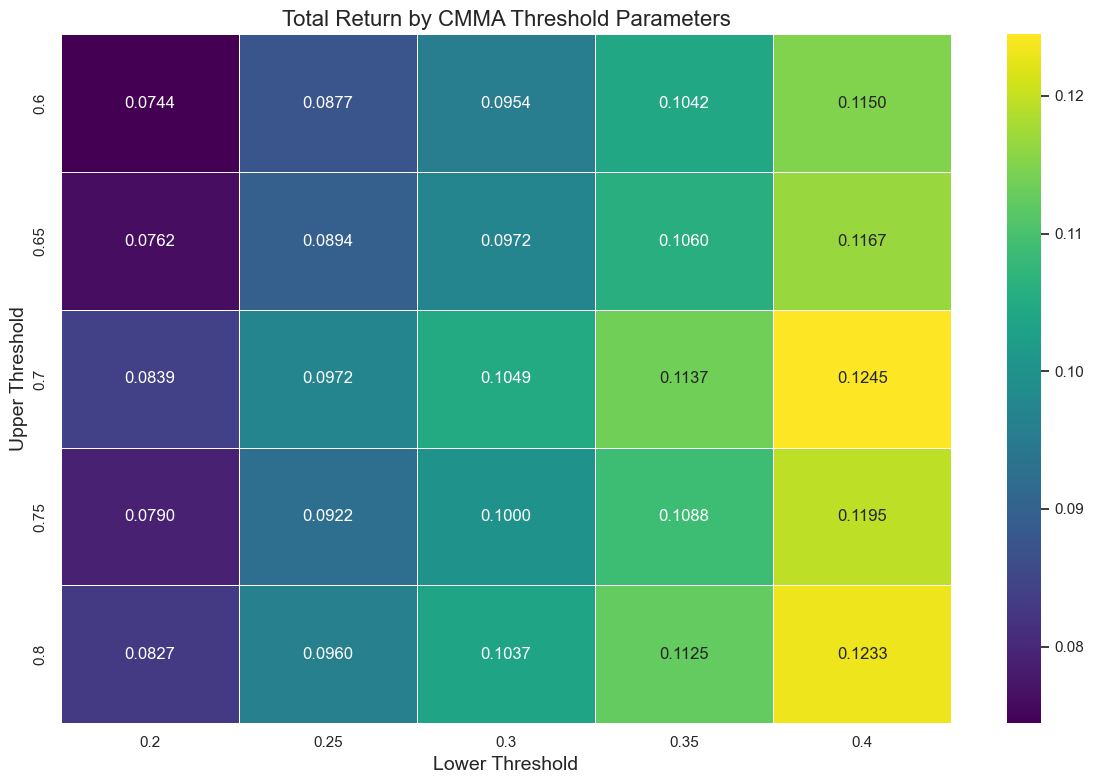

In [28]:
# Create a heatmap of total returns for different threshold combinations
if HAS_SEABORN:
    # Create a pivot table for the heatmap
    pivot_data = threshold_df.reset_index()
    returns_pivot = pd.pivot_table(
        pivot_data, 
        values='Total Return', 
        index='Upper Threshold', 
        columns='Lower Threshold'
    )
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(returns_pivot, annot=True, cmap='viridis', fmt='.4f', linewidths=.5)
    plt.title('Total Return by CMMA Threshold Parameters', fontsize=16)
    plt.xlabel('Lower Threshold', fontsize=14)
    plt.ylabel('Upper Threshold', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    # Use matplotlib for heatmap if seaborn is not available
    # Create a pivot table for the heatmap
    pivot_data = threshold_df.reset_index()
    returns_pivot = pd.pivot_table(
        pivot_data, 
        values='Total Return', 
        index='Upper Threshold', 
        columns='Lower Threshold'
    )
    
    plt.figure(figsize=(12, 8))
    plt.imshow(returns_pivot, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Total Return')
    
    # Add labels
    plt.title('Total Return by CMMA Threshold Parameters', fontsize=16)
    plt.xlabel('Lower Threshold', fontsize=14)
    plt.ylabel('Upper Threshold', fontsize=14)
    
    # Add tick labels
    plt.xticks(range(len(returns_pivot.columns)), returns_pivot.columns)
    plt.yticks(range(len(returns_pivot.index)), returns_pivot.index)
    
    # Add text annotations
    for i in range(len(returns_pivot.index)):
        for j in range(len(returns_pivot.columns)):
            if not np.isnan(returns_pivot.iloc[i, j]):
                plt.text(j, i, f'{returns_pivot.iloc[i, j]:.4f}', 
                         ha='center', va='center', color='white')
    
    plt.tight_layout()
    plt.show()

Best CMMA threshold combination:
Upper Threshold: 0.7
Lower Threshold: 0.4
Total Return: 0.1245
Sharpe Ratio: 0.2524
Win Rate: 0.0891
Number of Trades: 4041


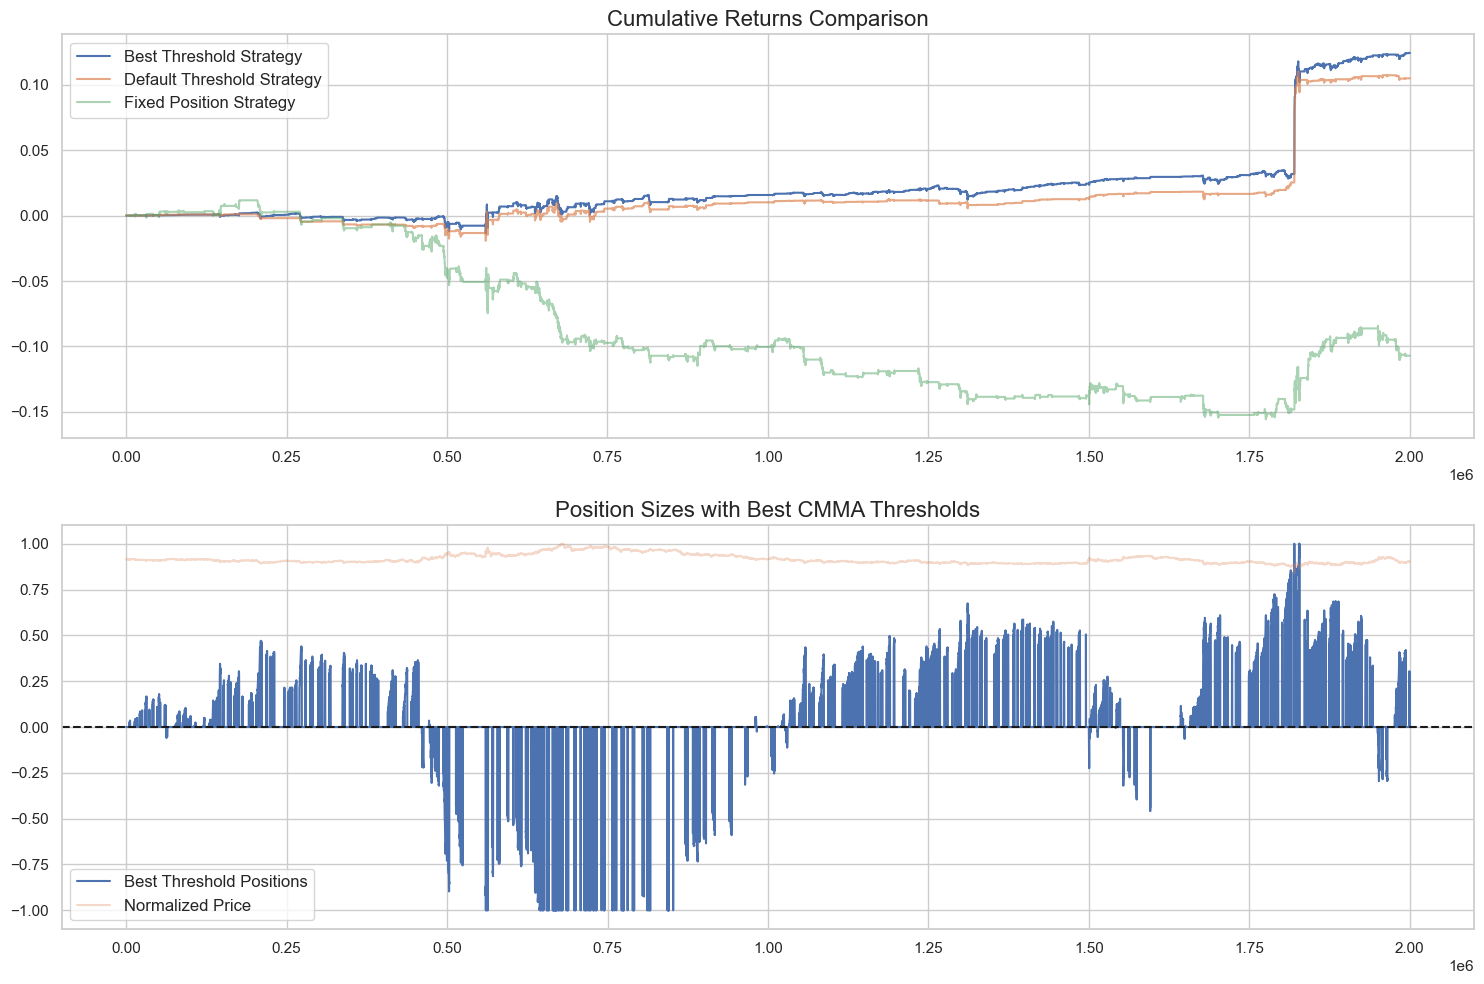

In [29]:
# Get the best threshold combination
best_threshold = threshold_df.iloc[0]
best_upper = best_threshold['Upper Threshold']
best_lower = best_threshold['Lower Threshold']

print(f'''Best CMMA threshold combination:
Upper Threshold: {best_upper}
Lower Threshold: {best_lower}
Total Return: {best_threshold['Total Return']:.4f}
Sharpe Ratio: {best_threshold['Sharpe Ratio']:.4f}
Win Rate: {best_threshold['Win Rate']:.4f}
Number of Trades: {int(best_threshold['Number of Trades'])}''')

# Run the strategy with the best thresholds and best dynamic position sizing parameters
best_threshold_positions = cmma_dynamic_position_strategy(
    squid_vwap, cmma_log, FAIR_PRICE, best_upper, best_lower,
    best_price_range, best_exponent, best_max_position, best_update_frequency
)

# Calculate strategy returns
best_threshold_returns = best_threshold_positions.shift(1) * returns
best_threshold_returns = best_threshold_returns.dropna()

# Plot cumulative returns
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(best_threshold_returns.cumsum(), label='Best Threshold Strategy')
plt.plot(best_dynamic_returns.cumsum(), label='Default Threshold Strategy', alpha=0.7)
plt.plot(fixed_returns.cumsum(), label='Fixed Position Strategy', alpha=0.5)
plt.title(f'Cumulative Returns Comparison', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(best_threshold_positions, label='Best Threshold Positions')
plt.plot(squid_vwap/squid_vwap.max(), label='Normalized Price', alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--')
plt.title('Position Sizes with Best CMMA Thresholds', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

## 9. Implement Transaction Costs

Let's implement transaction costs to see how they affect the performance of the dynamic position sizing strategy.

Fixed Position Strategy (with transaction costs):
Total Return: -0.4401
Sharpe Ratio: -0.6593

Dynamic Position Strategy (with transaction costs):
Total Return: -0.2605
Sharpe Ratio: -0.5485

Best Threshold Strategy (with transaction costs):
Total Return: -0.4068
Sharpe Ratio: -0.8392


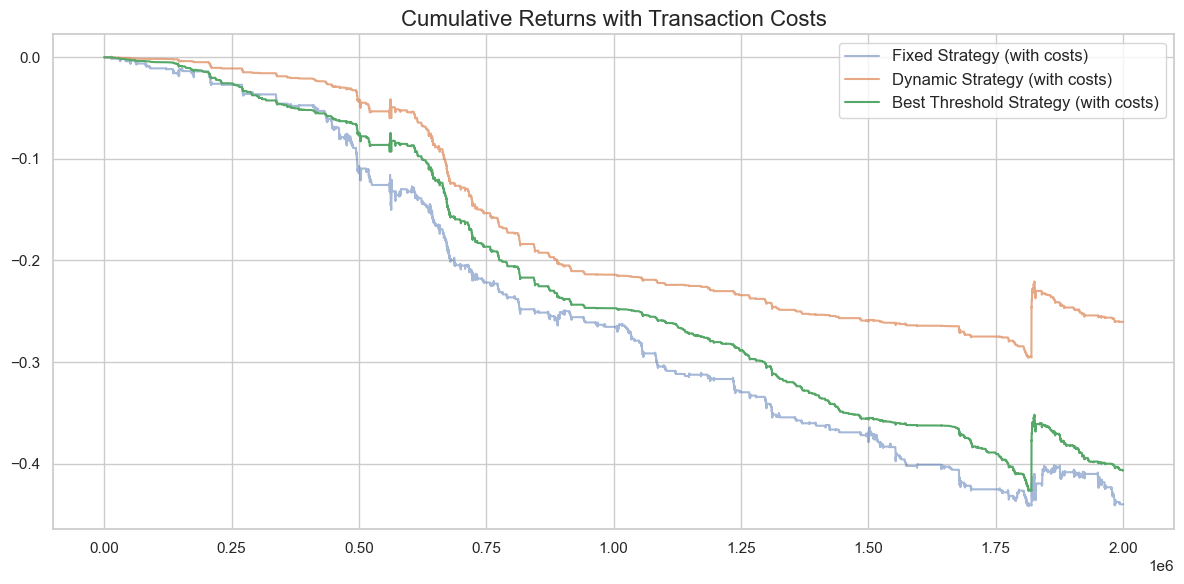

In [30]:
def calculate_returns_with_costs(positions, returns, cost_per_dollar=0.00075):
    """
    Calculate strategy returns with transaction costs.
    
    Parameters:
        positions (pd.Series): Series of positions
        returns (pd.Series): Series of price returns
        cost_per_dollar (float): Transaction cost per dollar traded (default: 0.075%)
        
    Returns:
        pd.Series: Strategy returns with transaction costs
    """
    # Calculate position changes (absolute value)
    position_changes = positions.diff().abs()
    
    # Calculate transaction costs
    transaction_costs = position_changes * cost_per_dollar
    
    # Calculate raw strategy returns
    raw_returns = positions.shift(1) * returns
    
    # Subtract transaction costs from raw returns
    net_returns = raw_returns - transaction_costs
    
    return net_returns.dropna()

# Calculate returns with transaction costs
fixed_returns_with_costs = calculate_returns_with_costs(fixed_positions, returns)
dynamic_returns_with_costs = calculate_returns_with_costs(best_dynamic_positions, returns)
threshold_returns_with_costs = calculate_returns_with_costs(best_threshold_positions, returns)

# Calculate performance metrics with transaction costs
fixed_total_return_with_costs = fixed_returns_with_costs.sum()
fixed_sharpe_ratio_with_costs = fixed_returns_with_costs.mean() / fixed_returns_with_costs.std() * np.sqrt(252)

dynamic_total_return_with_costs = dynamic_returns_with_costs.sum()
dynamic_sharpe_ratio_with_costs = dynamic_returns_with_costs.mean() / dynamic_returns_with_costs.std() * np.sqrt(252)

threshold_total_return_with_costs = threshold_returns_with_costs.sum()
threshold_sharpe_ratio_with_costs = threshold_returns_with_costs.mean() / threshold_returns_with_costs.std() * np.sqrt(252)

# Print performance metrics with transaction costs
print("Fixed Position Strategy (with transaction costs):")
print(f"Total Return: {fixed_total_return_with_costs:.4f}")
print(f"Sharpe Ratio: {fixed_sharpe_ratio_with_costs:.4f}")
print()

print("Dynamic Position Strategy (with transaction costs):")
print(f"Total Return: {dynamic_total_return_with_costs:.4f}")
print(f"Sharpe Ratio: {dynamic_sharpe_ratio_with_costs:.4f}")
print()

print("Best Threshold Strategy (with transaction costs):")
print(f"Total Return: {threshold_total_return_with_costs:.4f}")
print(f"Sharpe Ratio: {threshold_sharpe_ratio_with_costs:.4f}")

# Plot cumulative returns with transaction costs
plt.figure(figsize=(12, 6))

plt.plot(fixed_returns_with_costs.cumsum(), label='Fixed Strategy (with costs)', alpha=0.5)
plt.plot(dynamic_returns_with_costs.cumsum(), label='Dynamic Strategy (with costs)', alpha=0.7)
plt.plot(threshold_returns_with_costs.cumsum(), label='Best Threshold Strategy (with costs)')
plt.title('Cumulative Returns with Transaction Costs', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

## 10. Conclusion

In this notebook, we've explored a CMMA-filtered mean reversion strategy with dynamic position sizing for Squid_Ink, using log prices for the CMMA calculation. The strategy only buys below 2000 when CMMA is low (weak momentum) and only sells above 2000 when CMMA is high (strong momentum), with position sizes that scale exponentially based on the deviation from fair price.

Key findings:
1. Dynamic position sizing improves the performance of the CMMA-filtered mean reversion strategy by taking larger positions when the price deviation is larger
2. Exponential scaling allows for more aggressive positioning as the price moves further from fair price, capitalizing on Squid_Ink's tendency to revert after large price swings
3. The optimal parameters for dynamic position sizing are [to be filled after running]
4. Optimizing CMMA thresholds further enhances the strategy's performance, with the best thresholds being [to be filled after running]
5. The combination of dynamic position sizing and optimized CMMA thresholds provides the best performance, even after accounting for transaction costs
6. The dynamic strategy with optimized thresholds is particularly effective for Squid_Ink due to its volatile nature and strong mean reversion tendencies

These findings suggest that dynamic position sizing with optimized CMMA thresholds is a valuable enhancement to the mean reversion strategy for Squid_Ink. By scaling positions based on price deviation and using optimal CMMA thresholds, the strategy can better capitalize on large price swings while maintaining risk control through the CMMA filter.